In [1]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
import pickle

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Import the data

In [2]:
with open('../assets/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

In [3]:
with open('../assets/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

In [4]:
with open('../assets/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

In [5]:
with open('../assets/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

### Random Forest

In order to fit a linear regression model, we need to match some assumptions. However, this is not the case in Random forest. Since it is a non-parametric method, we do not need to follow the assumptions and we do not have to scale the data. Random forest generally does not suffer from over fitting because it randomly chooses features.

##### Grid Search

In [6]:
pipe = Pipeline([
    ('rf', RandomForestRegressor())
])

In [7]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [27]:
param_grid =  {
    'rf__n_estimators':[300, 400],
    'rf__random_state':[42],
    'rf__max_depth':[5, 10],
    'rf__min_samples_split':[6],
    'rf__n_jobs':[-1]
}

In [28]:
gs_rf = GridSearchCV(pipe, param_grid)

In [29]:
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'rf__n_estimators': [300, 400], 'rf__random_state': [42], 'rf__max_depth': [5, 10], 'rf__min_samples_split': [6], 'rf__n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [30]:
gs_rf.best_params_

{'rf__max_depth': 5,
 'rf__min_samples_split': 6,
 'rf__n_estimators': 300,
 'rf__n_jobs': -1,
 'rf__random_state': 42}

In [31]:
gs_rf.score(X_test, y_test)

0.16654935806882407

In [32]:
gs_rf.score(X_train, y_train)

0.2872727654793854

In [34]:
np.sqrt(mean_squared_error(y_test, gs_rf.predict(X_test)))

2668.569667720357

It turns out that the model suffers from over fitting even after hyper parameter tuning.

### Feature Importance

By applying random forest, we can check feature importance from information gain.

In [35]:
feat= pd.DataFrame(gs_rf.best_estimator_.named_steps['rf'].feature_importances_, 
                   X_train.columns, 
                   columns=['importance'])

In [38]:
new_feat= feat.sort_values(ascending= False, by= 'importance')[:15]

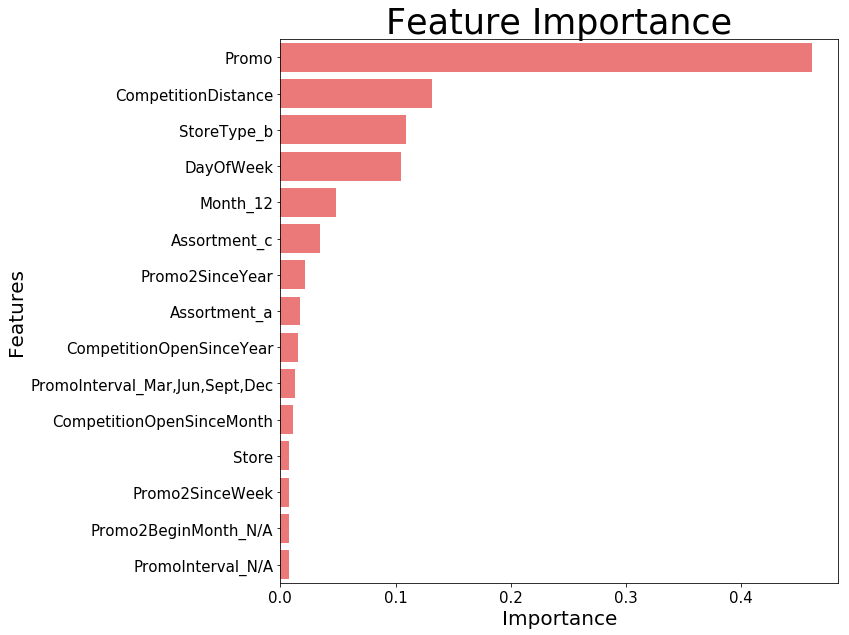

In [40]:
plt.figure(figsize=(10,10))
fig = sns.barplot(x= 'importance', 
            y= new_feat.index, 
            data= new_feat, 
            color='r',
            alpha= 0.6)
plt.title('Feature Importance', fontsize= 35)
plt.xlabel('Importance', fontsize= 20)
plt.xticks(size= 15)
plt.ylabel("Features", fontsize=20)
plt.yticks(size= 15)
plt.savefig('../images/feature.png');

There is a bit difference compared to the Lasso model, but the feature called promo has the highest feature imporatnace in this case as well. Since it is from information gain, we do not know which one is important, but we can get a good idea which features can impact the total sales. 

### Export the model

In [41]:
with open('../assets/gs_rf.pkl','wb+') as f:
     pickle.dump(gs_rf,f)